In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from skimage.io import imread 
from skimage.transform import resize 
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_DIR = r'..\\data\imagenes_gladiadores' 
NUM_CLASSES = 1 # Para clasificación binaria

print(f"Versión de TensorFlow: {tf.__version__}")
print(f"GPUs disponibles: {tf.config.list_physical_devices('GPU')}")

Versión de TensorFlow: 2.19.0
GPUs disponibles: []


In [7]:
#Cargo del Dataset de Imágenes 
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred", 
    label_mode='binary', 
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred", 
    label_mode='binary', 
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
print(f"Clases encontradas: {train_ds.class_names}")

Found 2042 files belonging to 2 classes.
Using 1634 files for training.
Found 2042 files belonging to 2 classes.
Using 408 files for validation.
Clases encontradas: ['test', 'train']


In [8]:
#Optimizo el rendimiento de la carga de datos
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
#Capas de Preprocesamiento y Aumento de Datos 
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2)
])

#Para VGG16:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [10]:
#Definición del Modelo 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
x = Dropout(0.6)(x)

predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)

In [11]:
#Compilación del Modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
print("Modelo CNN (VGG16) construido y compilado correctamente para clasificación binaria.")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Modelo CNN (VGG16) construido y compilado correctamente para clasificación binaria.


In [12]:
#Entrenamiento del Modelo (con Early Stopping)
EPOCHS = 20
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print(f"\nIniciando el entrenamiento del modelo por un máximo de {EPOCHS} épocas con Early Stopping...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping]
)
print("\nEntrenamiento completado (o detenido por Early Stopping).")


Iniciando el entrenamiento del modelo por un máximo de 20 épocas con Early Stopping...
Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 538s 10s/step - accuracy: 0.6650 - loss: 3.0667 - val_accuracy: 0.8186 - val_loss: 1.9423
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 409s 8s/step - accuracy: 0.7581 - loss: 2.2334 - val_accuracy: 0.8260 - val_loss: 1.8711
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 431s 8s/step - accuracy: 0.7722 - loss: 2.2057 - val_accuracy: 0.8235 - val_loss: 1.7668
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 409s 8s/step - accuracy: 0.7689 - loss: 1.9806 - val_accuracy: 0.8260 - val_loss: 1.6990
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 379s 7s/step - accuracy: 0.7729 - loss: 1.8594 - val_accuracy: 0.8137 - val_loss: 1.6272
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 457s 9s/step - accuracy: 0.7418 - loss: 1.8721 - val_accuracy: 0.8260 - val_loss: 1.5908
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 571s 11s/step - accuracy: 0.7958 - loss: 1.6184 - val_accuracy: 0.8235 - val_loss: 1.5341
Epoch 8/20
52/52 ━━━━

In [13]:
#Evaluación Final del Modelo
print("\nEvaluando el modelo en el conjunto de validación (como conjunto de prueba)...")
loss, accuracy = model.evaluate(val_ds)
print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")


Evaluando el modelo en el conjunto de validación (como conjunto de prueba)...
13/13 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.8550 - loss: 1.2657
Pérdida en el conjunto de prueba: 1.2571
Precisión en el conjunto de prueba: 0.8554


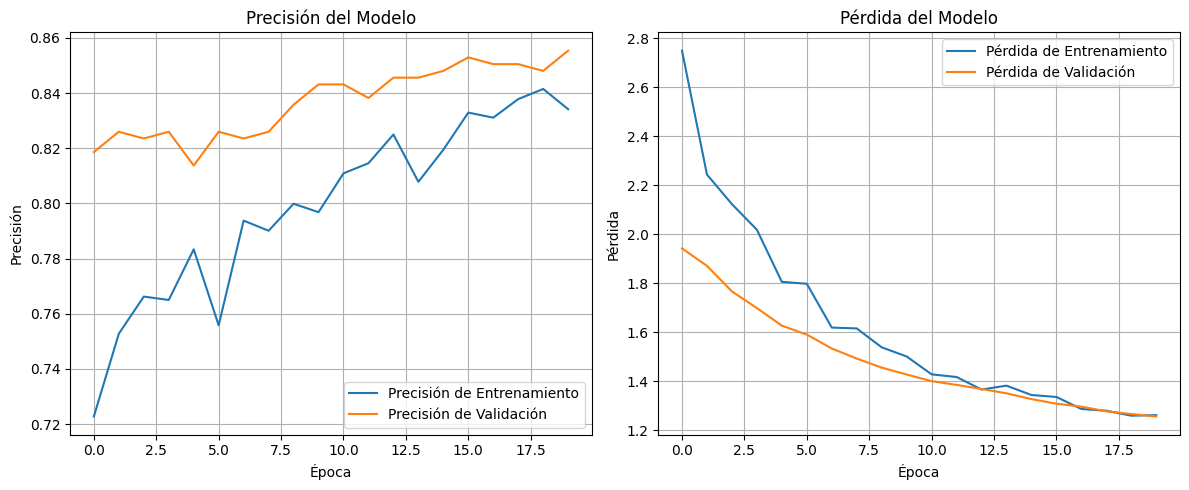

In [14]:
#Graficar el historial de entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión del Modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Defino la ruta y el nombre del archivo donde quiero guardar el modelo
output_directory = 'models'
model_filename = 'mi_modelo_VGG16.keras' # Nombre recomendado para modelos Keras
full_model_path = os.path.join(output_directory, model_filename)

#Me de que la carpeta de destino exista
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

#Guardo el modelo
try:
    model.save(full_model_path)
    print(f"Modelo guardado exitosamente en: {full_model_path}")
except Exception as e:
    print(f"Error al guardar el modelo: {e}")

Modelo guardado exitosamente en: models\mi_modelo_VGG16.keras


In [25]:
CLASS_NAMES = ['No_Gladiador', 'Gladiador']


--- ¡Listo para hacer una predicción con una nueva imagen! ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step

--- Resultado de la Predicción para la Nueva Imagen ---
El modelo predice que la imagen pertenece a la: **Gladiador**
Con una confianza del: 99.98%
Probabilidad de la clase positiva: 0.9998


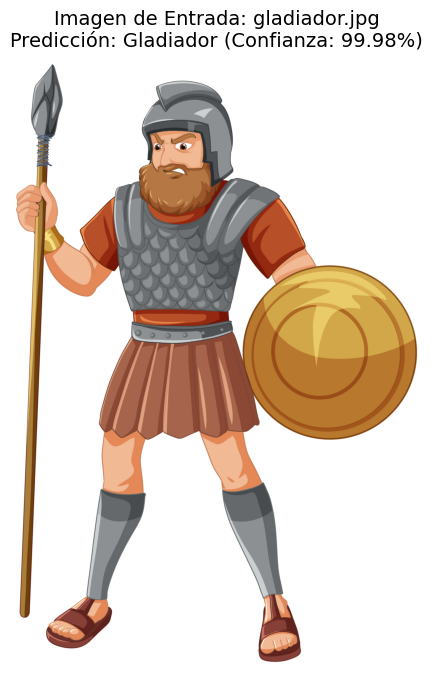

In [ ]:
#FUNCIÓN NECESARIA PARA EL PREPROCESAMIENTO DE UNA SOLA IMAGEN
def preprocess_single_image(image_path, target_size, normalize_func=None):

    # Cargar la imagen
    img = imread(image_path)

    # Redimensionar la imagen
    # resize devuelve float en [0, 1] si el tipo de dato original era int.
    # Si la imagen es en escala de grises y se espera RGB, es necesario convertirla.
    if len(img.shape) == 2: # Si es escala de grises
        img = np.stack([img, img, img], axis=-1) # Convertir a RGB duplicando canales
    elif img.shape[2] == 4: # Si es RGBA
        img = img[:, :, :3] # Eliminar el canal alfa

    # Asegurarse de que sea de tipo float antes de redimensionar si es necesario
    img_resized = resize(img, target_size)

    # Convertir a array de numpy y expandir dimensiones para el batch (1, height, width, channels)
    img_array = np.expand_dims(img_resized, axis=0)

    # Aplicar normalización específica de la arquitectura si se proporciona
    if normalize_func:
        # Asegúrate de que el tipo de dato sea compatible con la función de preprocesamiento
        # Las funciones de preprocesamiento de Keras a menudo esperan floats
        img_array = normalize_func(img_array * 255.0) # Multiplicar por 255 para llevar a 0-255 antes de preprocesar
    else:
        # Si no hay función de normalización específica, escalar a [0, 1] si los píxeles no están ya en ese rango
        if img_array.max() > 1.0:
            img_array /= 255.0

    return img_array

# --- Realizar la Predicción con una Imagen Introducida Manualmente ---
print("\n--- ¡Listo para hacer una predicción con una nueva imagen! ---")
image_path_input = image_path_to_predict = r'..\\data\predict\gladiador.jpg'


try:
    # 1. Preprocesar la imagen de entrada
    # Usamos preprocess_input de VGG16 (tf.keras.applications.vgg16.preprocess_input)
    # que está definida en tu código principal.
    processed_image = preprocess_single_image(image_path_input, IMAGE_SIZE, normalize_func=preprocess_input)

    # 2. Realizar la predicción utilizando el modelo cargado
    predictions = model.predict(processed_image)

    # 3. Interpretar los resultados de la predicción
    # Para NUM_CLASSES = 1 y activación 'sigmoid', la salida es una probabilidad única.
    # Si la probabilidad es > 0.5, se considera de la clase 1, de lo contrario clase 0.
    # El índice de la clase predicha se obtiene así:
    predicted_class_index = (predictions[0] > 0.5).astype(int)[0] # Para salida sigmoide binaria
    confidence = predictions[0][0] # La probabilidad directa de la clase positiva (1)

    print("\n--- Resultado de la Predicción para la Nueva Imagen ---")
    print(f"El modelo predice que la imagen pertenece a la: **{CLASS_NAMES[predicted_class_index]}**")
    print(f"Con una confianza del: {confidence:.2%}")
    print(f"Probabilidad de la clase positiva: {predictions[0][0]:.4f}") # Mostrar solo la probabilidad de la clase positiva

    # --- Opcional: Visualizar la imagen de entrada y su predicción ---
    plt.figure(figsize=(10, 8))
    img_display = imread(image_path_input)
    plt.imshow(img_display)
    plt.title(f"Imagen de Entrada: {os.path.basename(image_path_input)}\nPredicción: {CLASS_NAMES[predicted_class_index]} (Confianza: {confidence:.2%})", fontsize=14)
    plt.axis('off')
    plt.show()

except FileNotFoundError as e:
    print(f"\nError: {e}")
    print("Por favor, verifica que la ruta de la imagen que has introducido es correcta y que el archivo existe.")
except Exception as e:
    print(f"\nOcurrió un error inesperado durante el preprocesamiento o la predicción: {e}")
    print("Asegúrate de que la imagen es un formato compatible (ej. .jpg, .png) y no está corrupta.")